# LCF Analysis

This example uses lcf to analayse a large time resolved XAS dataset

In absence of further data, the process is:
Make a list of the files in the dataset, assuming the naming is tied to the time when spectra was collected.
- Read the first spectra, T<sub>0</sub>
- Read the last spectra, T<sub>n</sub>
- Set T<sub>0</sub> as the first component of the LCF
- Set T<sub>n</sub> as the second component of the LCF
- Do a binary search for the spectra T<sub>x</sub> where the signal from T<sub>n</sub> is greather than the signal from T<sub>0</sub>

The binary search proceeds as follows:
1. Set the search range as \[0,n\]
2. Read the middle spectra T<sub>n/2</sub>
3. Do a LCF using T<sub>0</sub> and T<sub>n</sub>
4. If the contribution of T<sub>n</sub> is greather than the contribution of T<sub>0</sub> set the search range  = \[0, n/2\] and repeat from 2.
5. If the contribution of T<sub>n</sub> is smaller than the contribution of T<sub>0</sub> set the search range  = \[n/2, n\] and repeat from 2.




## Resources
Pyhon modules and libraries used in this example

In [1]:
# code for importing custom helper libraries
import sys

# working with zipped files
import zipfile

# moved all custom helper libraries to a level bellow this directory.
sys.path.append('../lib/')

# Library with the functions that provide the larch functionalities
# equivalent to those provided by athena including normalisation, 
# merging, re-binning, LCF and visualisation (plotting)
import manage_athena as athenamgr 

# library to read ascii files
# this should be in the athenamgr lib
from larch.io import read_ascii

# additional custom plot functions (replicate plots in published papers)
import custom_plots

# File handling
from pathlib import Path

# Handling json files
import json

# printing formated json data
import pprint

# to copy the mutable types like dictionaries, use copy/deepcopy 
import copy

#plotting library
import matplotlib.pyplot as plt
# inline: shows plot in notebook
# tk: shows plot in popup
%matplotlib inline 

def get_file_list_zip(zip_file = ""):
    files_list = []
    if Path(zip_file).is_file():
        zip_data = zipfile.ZipFile(zip_file)
        files_list = zip_data.namelist()
    return files_list

def xas_from_zip(zip_file="", zipped_file_name="", columns = ""):
    work_dir = "./wd_temp"
    tmp_file = Path(zipped_file_name).name
    a_data_group = None
    if Path(zip_file).is_file():
        zip_data = zipfile.ZipFile(zip_file)
        # extract a specific file from the zip container
        f = zip_data.open(zipped_file_name)

        # save the extraced file 
        content = f.read()
               
        working_file = Path(work_dir, tmp_file)
    
        working_file.parents[0].mkdir(parents=True, exist_ok=True)
        
        f = open(working_file, 'wb')
        f.write(content)
        f.close()
        
        a_data_group = read_ascii(working_file, columns)
        
    return a_data_group

# LCF plot
def lcf_plot(group1, group2, xlim=[29180, 29230]):
    plt.plot(group1.energy, group1.norm, label=group1.filename, linewidth=2,color='blue')
    plt.plot(group2.energy, group2.norm, label=group2.filename, linewidth=1, color='orange',linestyle='--')
    plt.grid(color='black', linestyle=':', linewidth=1) #show and format grid
    plt.title(group2.arrayname, fontsize=8)
    plt.legend() # show legend 
    plt.xlim(xlim)

    return plt


In [2]:
# zip file containign normalised mu for the experiment
rh4co_01 = Path("../wf_data/rh4co", "37119_Rh_4_CO_Oxidation_53_second_ascii.zip")
rh4co_02 = Path("../wf_data/rh4co", "37123_Rh_4_CO_Oxidation_45_7_ascii.zip") 
        
# def get_data(zip, name)
files_list = get_file_list_zip(rh4co_02)
print ("The first file is ", files_list [0])
print ("The last file is ", files_list [-1])
print (f"There are: {len(files_list)} files in the zip file")


first_dg = xas_from_zip(rh4co_02, files_list [0], columns = "energy mu")
first_dg.filename = 'first'
last_dg = xas_from_zip(rh4co_02, files_list [-1], columns = "energy mu")
last_dg.filename = 'last'
lcf_components = {"first": first_dg, "last": last_dg}

for a_dg in lcf_components:
    lcf_components[a_dg] = athenamgr.calc_with_defaults(lcf_components[a_dg])

The first file is  37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_00000.dat
The last file is  37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_03999.dat
There are: 4000 files in the zip file


In [3]:
lcf_components['first'].filename

'first'

first 23225.067
last 23224.387


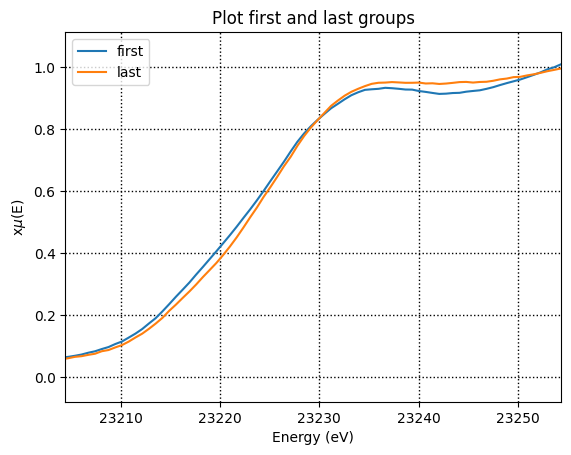

In [4]:
for a_dg in lcf_components:
    plt = athenamgr.plot_mu(lcf_components[a_dg])  
    plt.title("Plot first and last groups")
    plt.xlim(lcf_components[a_dg].e0-20,lcf_components[a_dg].e0+30)
    print(lcf_components[a_dg].filename, lcf_components[a_dg].e0)
plt.show()


In [5]:
# parameters for lcf 
task_lcf = {'name': 'lcf',
            'sequence': 1,
            'variables': {'lcf_components': ['first', 'last'],
                          'reference_standard': 'first',
                          'lower_limit': -20,
                          'upper_limit': 30,
                          'prefix':"rh4co_ox_"}}

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_01999.dat
23224.387
OrderedDict([('first', 0.31450814657501264), ('last', 0.6854918581115239)])
Goodness of LCF fit
37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_01999.dat R Factor:	 0.0000


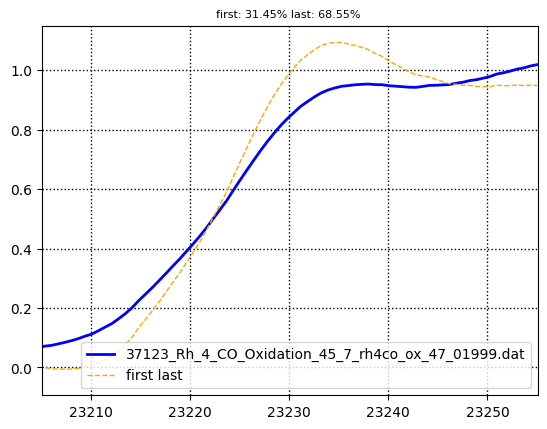

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_00999.dat
23225.067
OrderedDict([('first', 1.031759714730591), ('last', -0.031759699356173066)])
Goodness of LCF fit
37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_00999.dat R Factor:	 0.0000


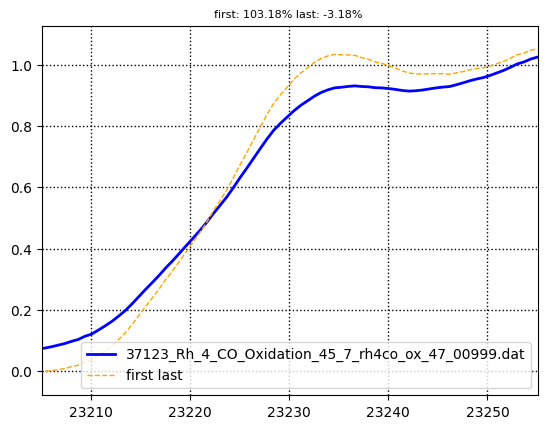

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_01499.dat
23225.067
OrderedDict([('first', 0.9977043142796493), ('last', 0.0022957005873035508)])
Goodness of LCF fit
37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_01499.dat R Factor:	 0.0000


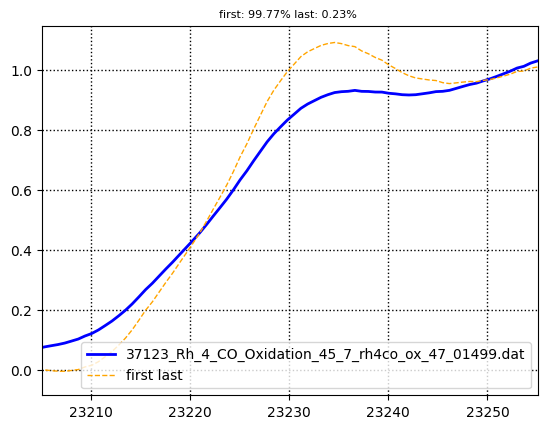

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_01749.dat
23225.067
OrderedDict([('first', 0.5129252148065349), ('last', 0.48707479283664645)])
Goodness of LCF fit
37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_01749.dat R Factor:	 0.0000


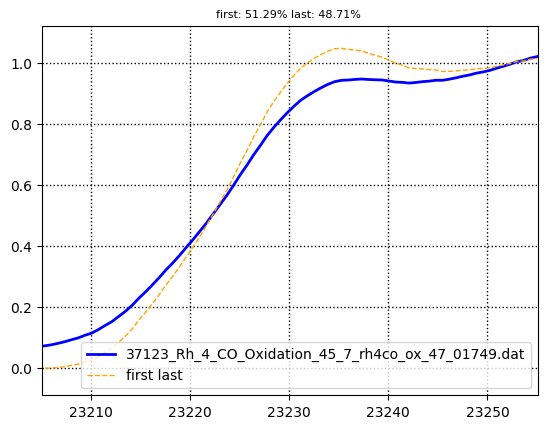

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_01874.dat
23225.067
OrderedDict([('first', 0.5183798334079608), ('last', 0.4816201743165007)])
Goodness of LCF fit
37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_01874.dat R Factor:	 0.0000


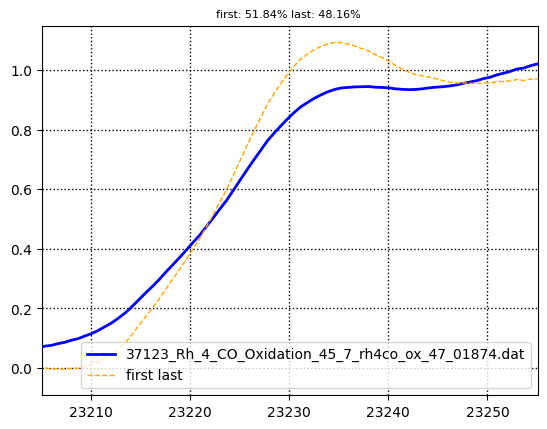

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_01936.dat
23225.067
OrderedDict([('first', 0.4483305812208629), ('last', 0.5516694254597834)])
Goodness of LCF fit
37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_01936.dat R Factor:	 0.0000


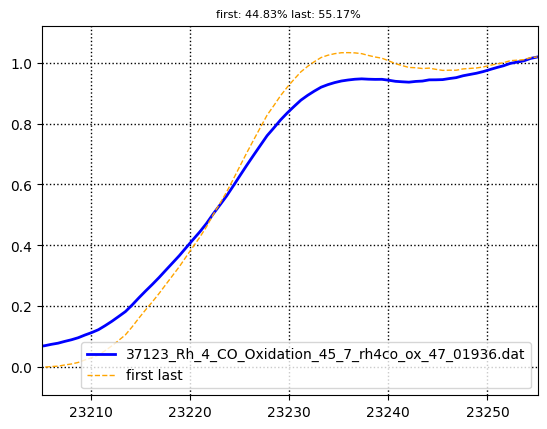

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_01905.dat
23225.067
OrderedDict([('first', 0.33485949905991447), ('last', 0.6651405059298809)])
Goodness of LCF fit
37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_01905.dat R Factor:	 0.0000


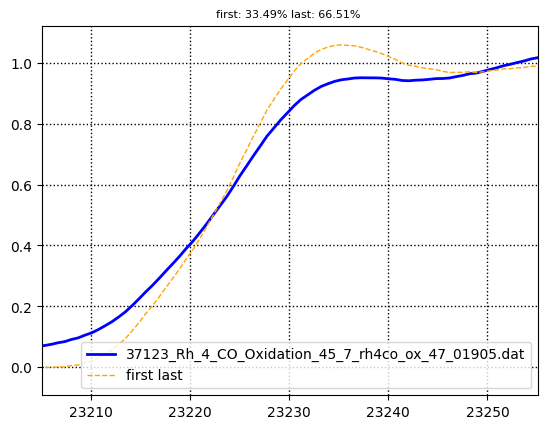

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_01889.dat
23225.067
OrderedDict([('first', 0.34792405217926664), ('last', 0.6520759530052057)])
Goodness of LCF fit
37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_01889.dat R Factor:	 0.0000


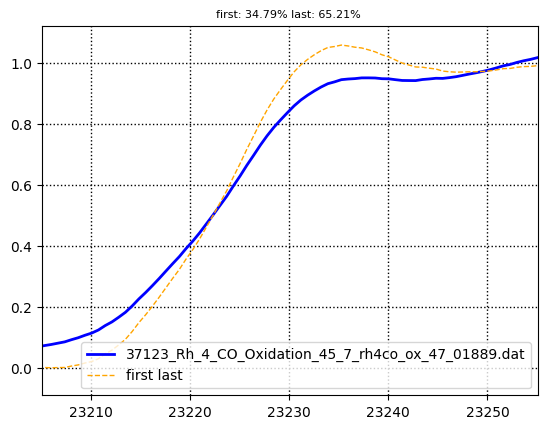

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_01881.dat
23225.067
OrderedDict([('first', 0.4097396539295282), ('last', 0.5902603521760684)])
Goodness of LCF fit
37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_01881.dat R Factor:	 0.0000


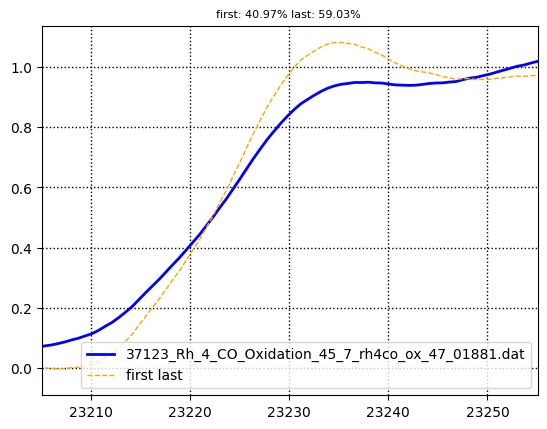

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_01877.dat
23225.067
OrderedDict([('first', 0.4718855495973678), ('last', 0.5281144574342749)])
Goodness of LCF fit
37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_01877.dat R Factor:	 0.0000


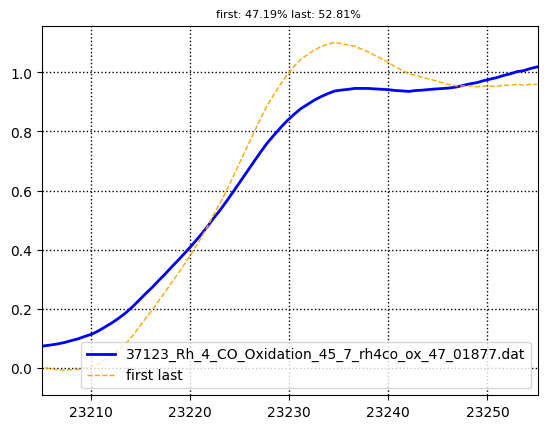

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_01875.dat
23225.067
OrderedDict([('first', 0.4964490053972048), ('last', 0.5035510020004619)])
Goodness of LCF fit
37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_01875.dat R Factor:	 0.0000


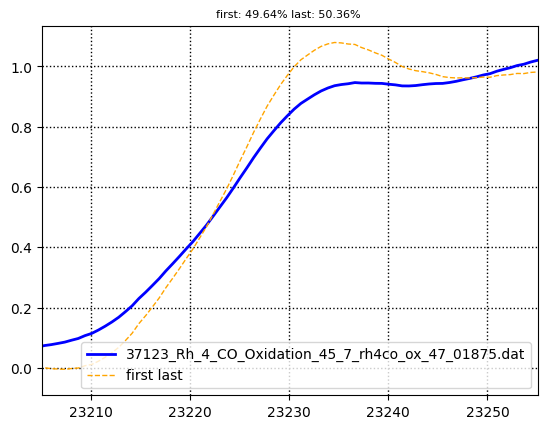

******************************************************************************************


In [6]:
# set L and R
lower_val = 0 
higher_val = len(files_list)-1

min_lim = lcf_components[task_lcf['variables']['reference_standard']].e0+ task_lcf['variables']['lower_limit']
max_lim = lcf_components[task_lcf['variables']['reference_standard']].e0+ task_lcf['variables']['upper_limit']

tested = {}
while higher_val > lower_val:
    mid_val = int(lower_val + (higher_val - lower_val) / 2)
    print(files_list[mid_val])
    test_dg = xas_from_zip(rh4co_02, files_list[mid_val], columns = "energy mu")
    test_dg = athenamgr.calc_with_defaults(test_dg)
    test_dg.label = task_lcf['variables']['prefix'] + "{:05d}".format(5)
    print(test_dg.e0)
    # do lcf of test group
    lcf_result = athenamgr.lcf_group(test_dg, 
                                     list(lcf_components.values()), 
                                     fit_limits=[min_lim, max_lim])
    weight_first = lcf_result.weights["first"] 
    weight_last = lcf_result.weights["last"] 
    print (lcf_result.weights)
    tested[mid_val] = [test_dg, lcf_result] 
    plt = lcf_plot(test_dg, lcf_result,[min_lim, max_lim])
    print("Goodness of LCF fit")
    print (test_dg.filename + " R Factor:\t", "%.4f" % lcf_result.rfactor)
    plt.show()
    # this finds the point closer to 50/50 split
    if weight_first >  weight_last:
        lower_val = mid_val    
    else:
        higher_val = mid_val
        
    if abs(lower_val - higher_val) == 1:
        print("*"*90)
        break

    

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_01999.dat
23224.387
OrderedDict([('first', 0.31450814657501264), ('last', 0.6854918581115239)])
Goodness of LCF fit
rh4co_ox_00005 R Factor:	 0.0000


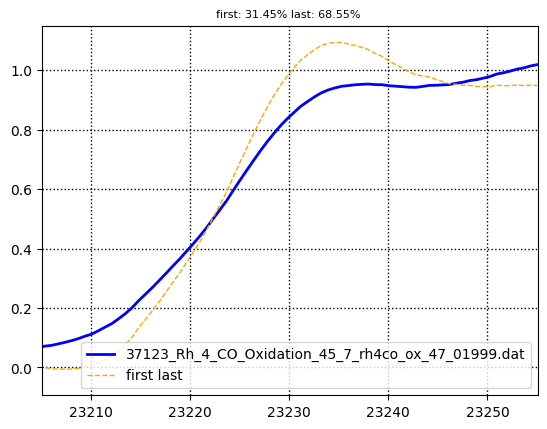

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_02999.dat
23224.387
OrderedDict([('first', 0.05081020118298611), ('last', 0.9491897995741448)])
Goodness of LCF fit
rh4co_ox_00005 R Factor:	 0.0000


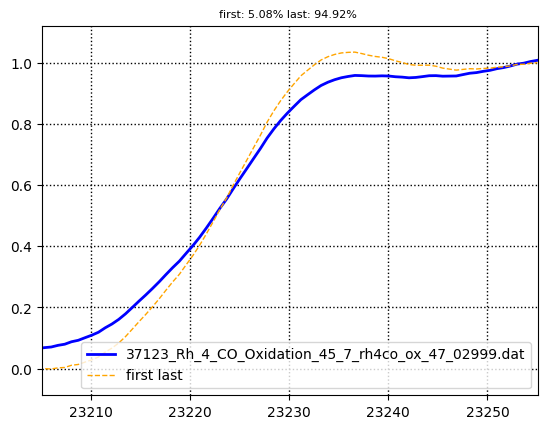

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_03499.dat
23225.067
OrderedDict([('first', 0.03128645660087476), ('last', 0.9687135438653298)])
Goodness of LCF fit
rh4co_ox_00005 R Factor:	 0.0000


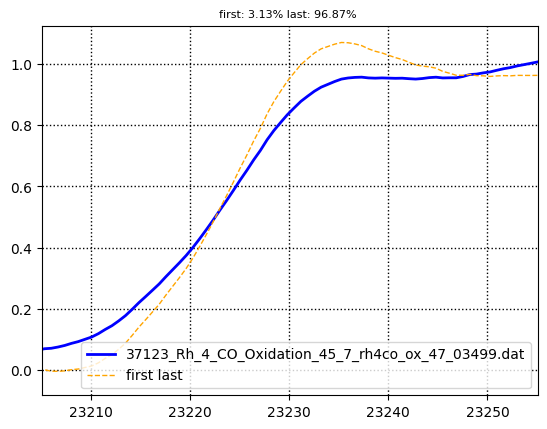

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_03749.dat
23225.748
OrderedDict([('first', 0.00388497615288963), ('last', 0.9961150239050011)])
Goodness of LCF fit
rh4co_ox_00005 R Factor:	 0.0000


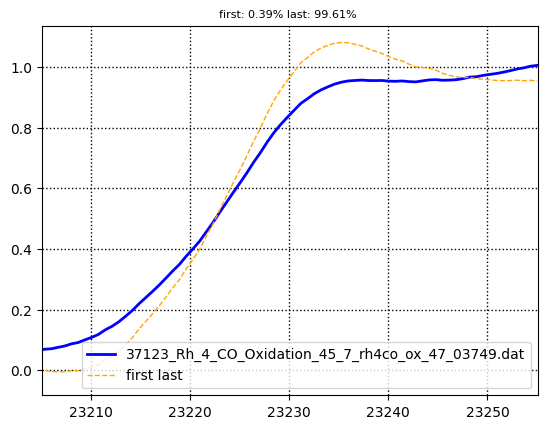

******************************************************************************************


In [7]:
# set L and R
lower_val = 0 
higher_val = len(files_list)-1

tested = {}
while higher_val > lower_val:
    mid_val = int(lower_val + (higher_val - lower_val) / 2)
    print(files_list[mid_val])
    test_dg = xas_from_zip(rh4co_02, files_list[mid_val], columns = "energy mu")
    test_dg = athenamgr.calc_with_defaults(test_dg)
    test_dg.label = task_lcf['variables']['prefix'] + "{:05d}".format(5)
    print(test_dg.e0)
    # do lcf of test group
    lcf_result = athenamgr.lcf_group(test_dg, 
                                     list(lcf_components.values()), 
                                     fit_limits=[min_lim, max_lim])
    weight_first = lcf_result.weights["first"] 
    weight_last = lcf_result.weights["last"] 
    print (lcf_result.weights)
    tested[mid_val] = [test_dg, lcf_result] 
    plt = lcf_plot(test_dg, lcf_result,[min_lim, max_lim])
    print("Goodness of LCF fit")
    print (test_dg.label + " R Factor:\t", "%.4f" % lcf_result.rfactor)
    plt.show()
    # this finds the point closer to 50/50 split
    if weight_first >  0.02:
        lower_val = mid_val    
    else:
        higher_val = mid_val
        
    if abs(lower_val - higher_val) == 1 or weight_first <  0.02:
        print("*"*90)
        break

    

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_01999.dat
23224.387
OrderedDict([('first', 0.31450814657501264), ('last', 0.6854918581115239)])
Goodness of LCF fit
rh4co_ox_00005 R Factor:	 0.0000


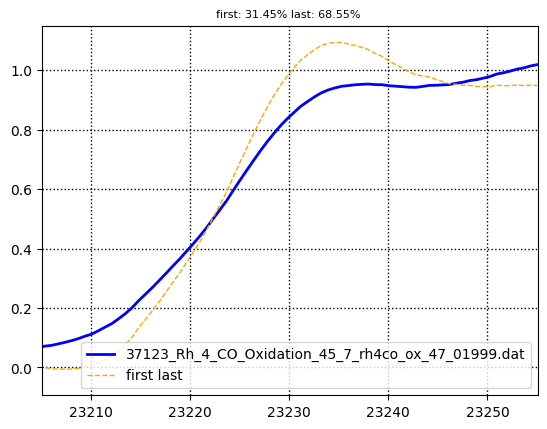

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_00999.dat
23225.067
OrderedDict([('first', 1.031759714730591), ('last', -0.031759699356173066)])
Goodness of LCF fit
rh4co_ox_00005 R Factor:	 0.0000


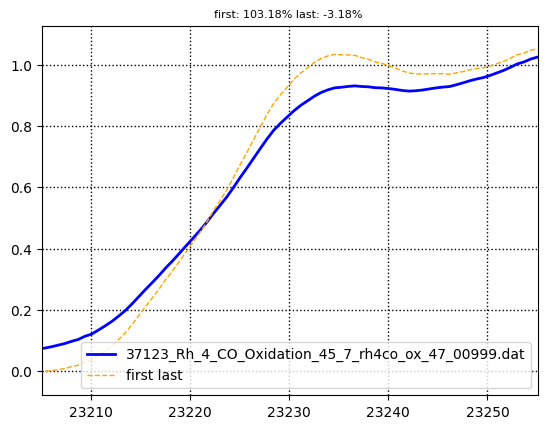

37123_Rh_4_CO_Oxidation_45_7_ascii/37123_Rh_4_CO_Oxidation_45_7_rh4co_ox_47_01499.dat
23225.067
OrderedDict([('first', 0.9977043142796493), ('last', 0.0022957005873035508)])
Goodness of LCF fit
rh4co_ox_00005 R Factor:	 0.0000


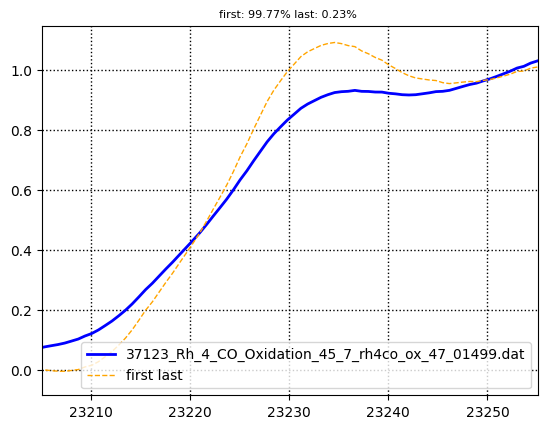

******************************************************************************************


In [8]:
# set L and R
lower_val = 0 
higher_val = len(files_list)-1

tested = {}
while higher_val > lower_val:
    mid_val = int(lower_val + (higher_val - lower_val) / 2)
    print(files_list[mid_val])
    test_dg = xas_from_zip(rh4co_02, files_list[mid_val], columns = "energy mu")
    test_dg = athenamgr.calc_with_defaults(test_dg)
    test_dg.label = task_lcf['variables']['prefix'] + "{:05d}".format(5)
    print(test_dg.e0)
    # do lcf of test group
    lcf_result = athenamgr.lcf_group(test_dg, 
                                     list(lcf_components.values()), 
                                     fit_limits=[min_lim, max_lim])
    weight_first = lcf_result.weights["first"] 
    weight_last = lcf_result.weights["last"] 
    print (lcf_result.weights)
    tested[mid_val] = [test_dg, lcf_result] 
    plt = lcf_plot(test_dg, lcf_result,[min_lim, max_lim])
    print("Goodness of LCF fit")
    print (test_dg.label + " R Factor:\t", "%.4f" % lcf_result.rfactor)
    plt.show()
    # this finds the point closer to 50/50 split
    if weight_last >  0.02:
        higher_val = mid_val     
    else:
        lower_val = mid_val
    if abs(lower_val - higher_val) == 1 or (weight_last <  0.02 and weight_last >  0.0):
        print("*"*90)
        break

    